# CycleGANs des données MNIST aux données USPS
Les CycleGANs servent à faire des traductions image-à-image. Cela consiste à convertir automatiquement une image en une nouvelle image avec une apparence désirée. Par exemple de la cadre de notre projet, nous travaillons sur des chiffres écrits à la main. L'image en entrée est une image de la base MNIST et l'image en sortie suit le standard du service postal américain (USPS). 

L'idée derrière les CycleGANs est d'utiliser des GANs pour générer des nouvelles images, mais sous des nouvelles contraintes : ressembler à une image en input, mais avec les caractéristiques des images de la deuxième base de données. L'avantage des CycleGANs est qu'on peut les utiliser sur des données qui ne sont pas pré-couplés : ils s'appliquent aux problèmes non supervisés. 

Pour l'implémentation du CycleGAN, nous allons effectuer une traduction image-à-image en passant de la base de données MNIST (que nous avions précédemment utilisé pour l'implémentation du DCGAN) à la base de données USPS.




## Set up

In [26]:
# importation des données
import h5py

# tensorflow
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

# outils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# mesure du temps
import time

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Données

### MNIST

In [3]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = tf.keras.datasets.mnist.load_data()

mnist_images = mnist_images.reshape(mnist_images.shape[0], mnist_images.shape[1], mnist_images.shape[2], 1).astype('float32')
mnist_images = (mnist_images - 127.5) / 127.5 # on normalise pour obtenir des valeurs dans l'intervalle [-1, 1]

mnist_images2 = np.ndarray(shape=(200, mnist_images.shape[1], mnist_images.shape[2], 3))
for i in range(mnist_images2.shape[0]):
    for j in range(mnist_images.shape[1]):
        for k in range(mnist_images.shape[2]):
            mnist_images2[i][j][k]=np.array([float(mnist_images[i][j][k]), float(mnist_images[i][j][k]), float(mnist_images[i][j][k])])

BUFFER_SIZE = mnist_images.shape[0]
BATCH_SIZE = 1
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_images2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### USPS

In [4]:
filename = "Data/usps.h5"
f = h5py.File(filename, 'r+')

train = f['train']
usps_images = np.array(train['data'])
usps_labels = np.array(train['target'])

test = f['test']
usps_images_test= np.array(test['data'])
usps_labels_test = np.array(test['target'])

usps_images = usps_images.reshape(usps_images.shape[0], int(np.sqrt(usps_images.shape[1])), int(np.sqrt(usps_images.shape[1])), 1).astype('float32')

usps_images2 = np.ndarray(shape=(200, usps_images.shape[1], usps_images.shape[2], 3))
for i in range(usps_images2.shape[0]):
    for j in range(usps_images.shape[1]):
        for k in range(usps_images.shape[2]):
            usps_images2[i][j][k]=np.array([float(usps_images[i][j][k]), float(usps_images[i][j][k]), float(usps_images[i][j][k])])

BUFFER_SIZE = usps_images.shape[0]
BATCH_SIZE = 1
usps_dataset = tf.data.Dataset.from_tensor_slices(usps_images2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Représentation d'un échantillon de données
Afin d'éviter l'overfitting, on applique :
* un random jittering : on redimensionne l'image à 286x286, puis on la coupe aléatoirement à 256x256
* un random mirroring : on retourne l'image à l'horizontale aléatoirement 

In [5]:
def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # on définit la taille à 286x286x3
    image = tf.image.random_crop(image, size=[256, 256, 3]) # on coupe l'image au hasard à 256x256x3
    image = tf.image.random_flip_left_right(image) # mise en symétrie aléatoire
    return image

In [6]:
sample_mnist = next(iter(mnist_dataset))
sample_usps = next(iter(usps_dataset))
sample_mnist = tf.image.resize(sample_mnist, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
sample_usps = tf.image.resize(sample_usps, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


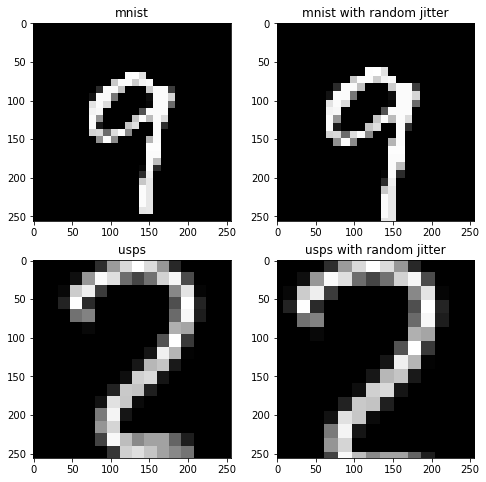

In [7]:
plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('mnist')
plt.imshow(sample_mnist[0], cmap='gray')

plt.subplot(222)
plt.title('mnist avec random jitter')
plt.imshow(random_jitter(sample_mnist[0]), cmap='gray')

plt.subplot(223)
plt.title('usps')
plt.imshow(sample_usps[0], cmap='gray')

plt.subplot(224)
plt.title('usps avec random jitter')
plt.imshow(random_jitter(sample_usps[0]), cmap='gray')

## Pix2Pix models

Pour l'implémentation du CycleGAN, nous réutilisons les générateur et discriminateur du modèle Pix2Pix, qui fait de la traduction image-à-image avec supervision. Nous importons le modèle à partir d'une librairie d'exemples de Tensorflow (`tensorflow_examples`).

L'architecture du modèle utilisé ets très similaire à ce qui est utilisé dans le modèle Pix2Pix.

Il y a deux générateurs ($G$ et $F$) qui sont entrainés, et deux discriminateurs ($D_X$ et $D_Y$) :
* Le générateur $G$ apprend à transformer les images $X$ en image $Y$
* Le générateur $F$ apprend à transformer les images $Y$ en image $X$
* Le discriminateur $D_X$ apprend à différentier les vraies images $X$ des images générées $X$
* Le discriminateur $D_Y$ apprend à différentier les vraies images $Y$ des images générées $Y$


In [8]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


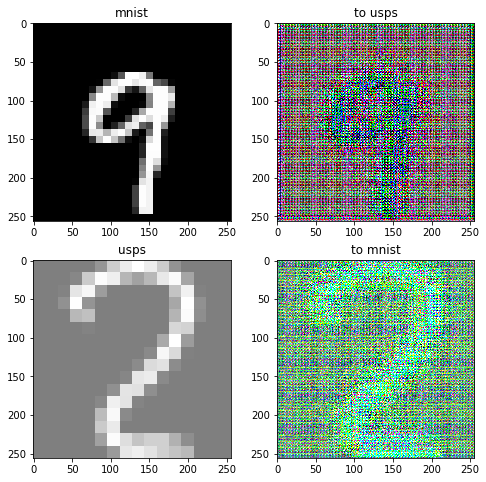

In [9]:
to_usps = generator_g(sample_mnist)
to_mnist = generator_f(sample_usps)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_mnist, to_usps, sample_usps, to_mnist]
title = ['mnist', 'to usps', 'usps', 'to mnist']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



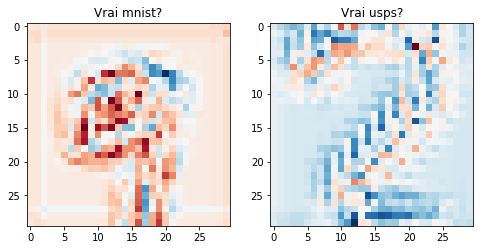

In [10]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Vrai mnist?')
plt.imshow(discriminator_x(sample_mnist)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Vrai usps?')
plt.imshow(discriminator_y(sample_usps)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Fonctions de perte
Dans les CycleGANs, il n'y a pas de données couplés pour l'entrainement, donc il n'y a aucune garantie que l'input x et la target y sient couplés de manière sensée durant l'entrainement.

C'est pourquoi, en plus des pertes des discriminateurs et des générateurs (identiques à celles du DCGAN), l'auteur ajoute une autre perte : la cycle consistency loss (perte de consistance du cycle). Un cycle de traduction est constant si la traduction d'une traduction est égale à son entrée. En d'autres termes, traduire une phrase du français vers l'anglais puis retraduire le résultat de l'anglais vers le français devrait résulter en la phrase originelle. Il en va de même pour les images.

Pour calculer la perte, on commence par transformer une image $X$ via le générateur $G$ : $G(X)=\hat{Y}$. Puis on transforme l'image $\hat{Y}$ via le générateur F : $F(\hat{Y})=\hat{X}$. On peut ensuite calculer la perte forward avec la MAE (mean absolute error) entre $X$ et la perte backward avec la MAE entre $Y$ et $\hat{Y}$.

L'auteur rajoute également une identity loss (perte d'identité) qui vérifie que le générateur chargé de transformer une image $X$ (resp. $Y$) en une image $Y$ (resp. $X$) génère la vraie image la vraie image $Y$ (resp. $X$) si $Y$ est l'input. En d'autres termes, on devrait avoir : $G(Y) = Y$ et $F(X) = X$. La perte calcule la somme des écarts.

In [11]:
LAMBDA = 10

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss / 2

In [14]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [15]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [16]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Fonctions d'opimisation

In [17]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [18]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored !!')

## Entrainement
La boucle d'entraînement est composée des 4 étapes suivantes :
1. Génération des images ($G(X)$, $F(G(X))$, $F(Y)$, $G(F(Y))$, $F(X)$ et $G(Y)$) et évaluation par le discriminateur ($D_X(X)$, $D_Y(Y)$, $D_X(F(Y))$ et $D_Y(G(X))$)
2. Calcul des pertes des générateurs, des discriminateurs, de la cycle consistency et d'identité.
3. Calcul des gradients par backpropagation
4. Mise à jour des gradients dans la fonction d'optimisation

In [19]:
EPOCHS = 40

In [21]:
@tf.function
def train_step(real_x, real_y):
    
    with tf.GradientTape(persistent=True) as tape:
        # étape 1 
        fake_y = generator_g(real_x, training=True) #G(X)
        cycled_x = generator_f(fake_y, training=True) #F(G(X))

        fake_x = generator_f(real_y, training=True) #F(Y)
        cycled_y = generator_g(fake_x, training=True) #G(F(Y))
    
        same_x = generator_f(real_x, training=True) #F(X)
        same_y = generator_g(real_y, training=True) #G(Y)

        disc_real_x = discriminator_x(real_x, training=True) #D_X(X)
        disc_real_y = discriminator_y(real_y, training=True) #D_Y(Y)

        disc_fake_x = discriminator_x(fake_x, training=True) #D_X(F(Y))
        disc_fake_y = discriminator_y(fake_y, training=True) #D_Y(G(X))

        # étape 2
        # pertes des générateurs
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # perte de consistance de cycle
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
        # perte totale des générateurs = perte des générateurs + perte de consistance de cycle + perte d'identité
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # perte des discriminateurs
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # étape 3 : calcul des gradients par backpropagation
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # étape 4 : mise à jour des gradients dans la fonction d'optimisation
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [51]:
def generate_images(model, test_input, j=0):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig('generate_image_{}.png'.format(j))
    plt.show()

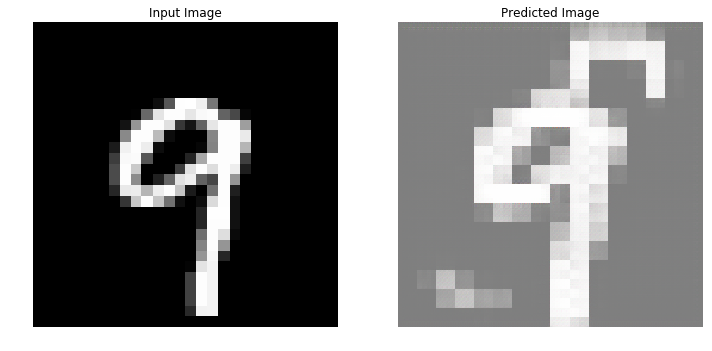

UnknownError: Failed to WriteFile: ./checkpoints/train\ckpt-5_temp_42985063271249d6a5da3c8fe4324452/part-00000-of-00001.data-00000-of-00001.tempstate10762836505915865857 : Espace insuffisant sur le disque.
; Unknown error [Op:SaveV2]

In [22]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((mnist_dataset, usps_dataset)):
        image_x = tf.image.resize(image_x, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image_y = tf.image.resize(image_y, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image_x = tf.cast(image_x, tf.float32)
        image_y = tf.cast(image_y, tf.float32)
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_mnist)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [30]:
mnist_images_test = mnist_images_test.reshape(mnist_images_test.shape[0], mnist_images_test.shape[1], mnist_images_test.shape[2], 1).astype('float32')
mnist_images_test = (mnist_images_test - 127.5) / 127.5 # on normalise pour obtenir des valeurs dans l'intervalle [-1, 1]

mnist_images_test2 = np.ndarray(shape=(200, mnist_images_test.shape[1], mnist_images_test.shape[2], 3))
for i in range(mnist_images_test2.shape[0]):
    for j in range(mnist_images_test.shape[1]):
        for k in range(mnist_images_test.shape[2]):
            mnist_images_test2[i][j][k]=np.array([float(mnist_images_test[i][j][k]), float(mnist_images_test[i][j][k]), float(mnist_images_test[i][j][k])])

BUFFER_SIZE = mnist_images_test.shape[0]
BATCH_SIZE = 1
mnist_dataset_test = tf.data.Dataset.from_tensor_slices(mnist_images_test2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

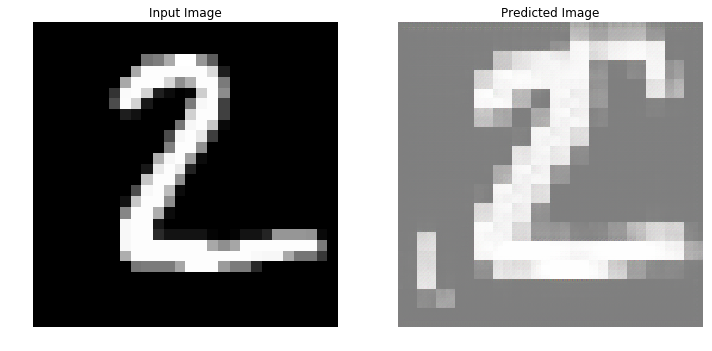

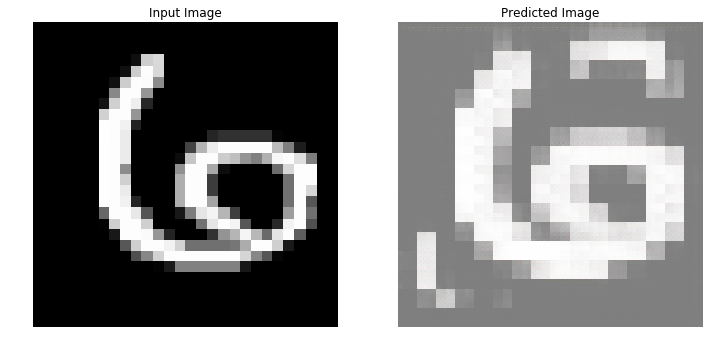

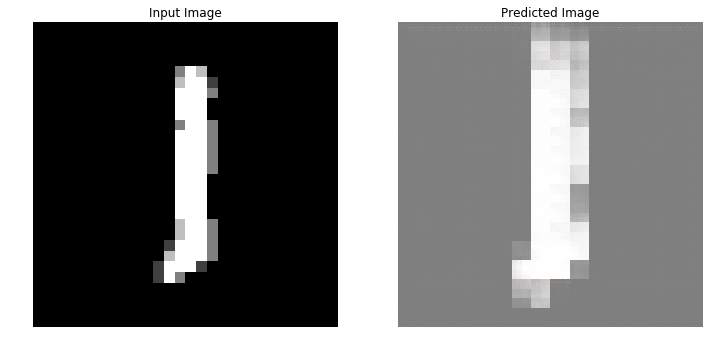

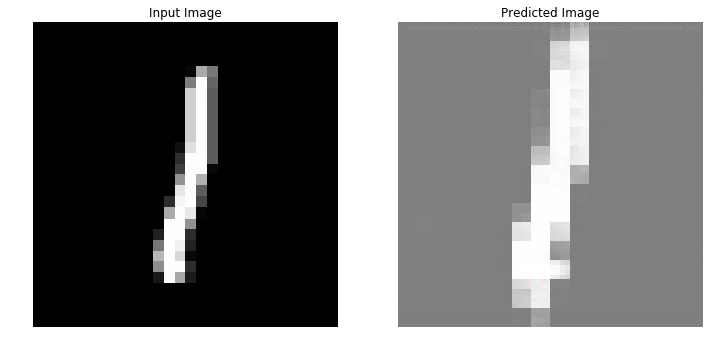

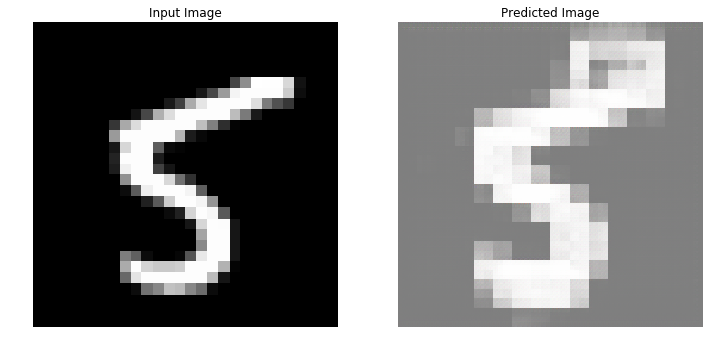

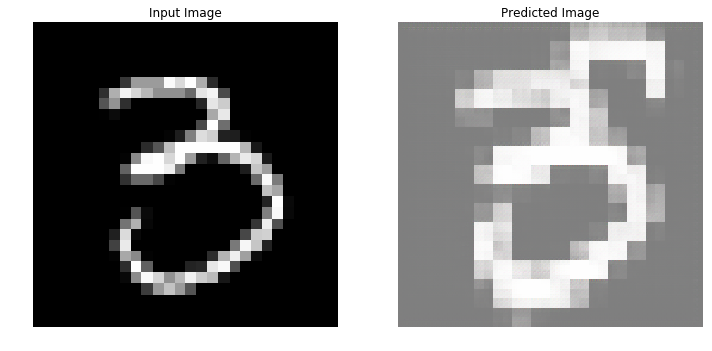

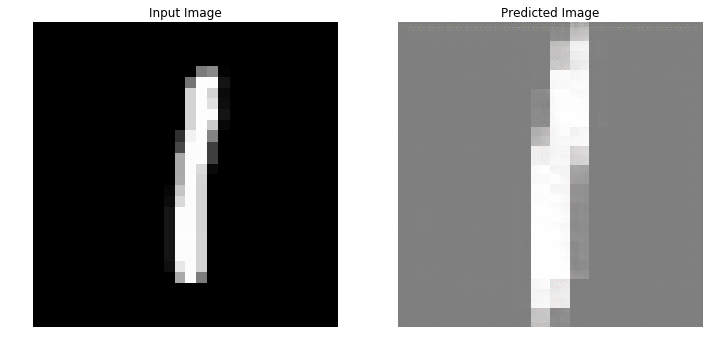

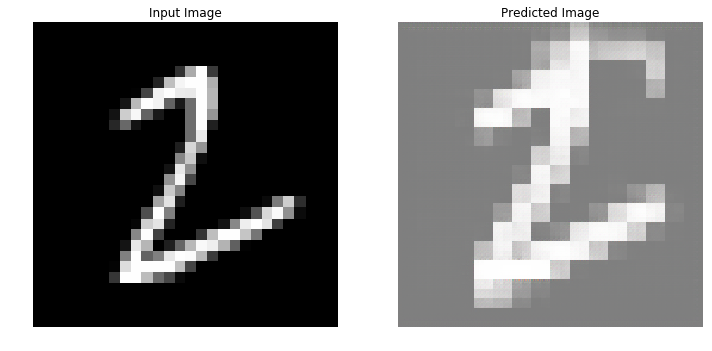

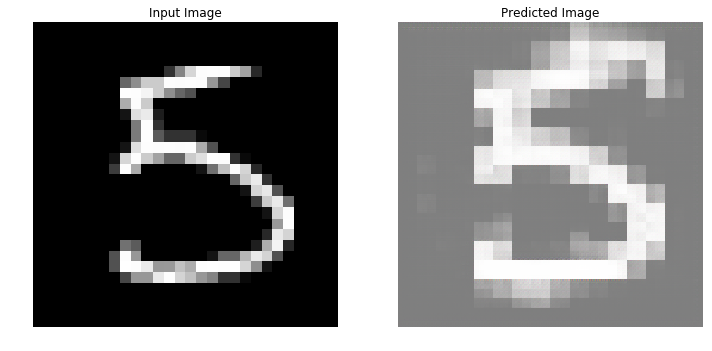

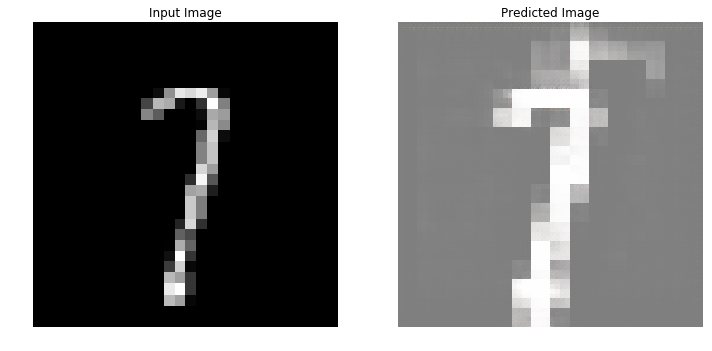

In [52]:
# Run the trained model on the test dataset
i = 0
for inp in mnist_dataset_test.take(10):
    i += 1
    inp = tf.image.resize(inp, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    inp = tf.cast(inp, tf.float32)
    plot = generate_images(generator_g, inp, i)